In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
#Loading the dataset
file_path = "C:/Users/nehap/Downloads/COVID-19_Reported_Patient_Impact_and_Hospital_Capacity_by_State_Timeseries__RAW__20250315_Updated.csv"

# Load dataset
df = pd.read_csv(file_path)

In [13]:
df['Staff Availability %'] = (
    df['critical_staffing_shortage_today_no'] /
    (df['critical_staffing_shortage_today_yes'] + df['critical_staffing_shortage_today_no']).replace(0, np.nan)
) * 100


In [23]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
# Drop irrelevant or non-numeric columns, include engineered Staff Availability %
features = df.drop(columns=['Staff Availability %', 'date', 'state'])
target = df['Staff Availability %']

# Drop rows where Staff Availability % is NaN
df = df.dropna(subset=['Staff Availability %'])

# Define features and target again after cleaning
features = df.drop(columns=['Staff Availability %', 'date', 'state'])  # drop non-numeric/categorical
target = df['Staff Availability %']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)




In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
pred_rf = model_rf.predict(X_test)

print("RF RMSE:", mean_squared_error(y_test, pred_rf, squared=False))


RF RMSE: 0.2549571097060923


C:\Users\nehap\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [33]:
import pandas as pd

# Ensure date column is datetime
df['date'] = pd.to_datetime(df['date'])

# Aggregate weekly staff availability by state
df_weekly = df.groupby(['state', pd.Grouper(key='date', freq='W-MON')])['Staff Availability %'].mean().reset_index()

# Sort by state and date
df_weekly = df_weekly.sort_values(by=['state', 'date'])

# Add lag features (e.g., 1 week, 2 weeks ago)
for lag in [1, 2, 3]:
    df_weekly[f'lag_{lag}'] = df_weekly.groupby('state')['Staff Availability %'].shift(lag)

# Drop rows with missing lags
df_weekly = df_weekly.dropna()


In [35]:
from sklearn.ensemble import RandomForestRegressor

# Features and target
feature_cols = ['lag_1', 'lag_2', 'lag_3']
X = df_weekly[feature_cols]
y = df_weekly['Staff Availability %']

# Train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)


RandomForestRegressor(random_state=42)

In [57]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.ensemble import RandomForestRegressor
import plotly.express as px


In [59]:
# Load your dataset (change path accordingly)
df = pd.read_csv("C:/Users/nehap/Downloads/COVID-19_Reported_Patient_Impact_and_Hospital_Capacity_by_State_Timeseries__RAW__20250315_Updated.csv")

# Ensure datetime
df['date'] = pd.to_datetime(df['date'])

# Keep necessary columns only
df = df[['date', 'state', 'critical_staffing_shortage_today_yes', 'critical_staffing_shortage_today_no']]

# Calculate Staff Availability %
df['Staff Availability %'] = (
    df['critical_staffing_shortage_today_no'] / 
    (df['critical_staffing_shortage_today_yes'] + df['critical_staffing_shortage_today_no'])
) * 100

# Drop any rows with missing data
df = df.dropna()


In [61]:
# Weekly state-level aggregation
df_weekly = df.groupby(['state', pd.Grouper(key='date', freq='W-MON')])['Staff Availability %'].mean().reset_index()

# Sort and add lag features
df_weekly = df_weekly.sort_values(by=['state', 'date'])
for lag in [1, 2, 3]:
    df_weekly[f'lag_{lag}'] = df_weekly.groupby('state')['Staff Availability %'].shift(lag)

df_weekly = df_weekly.dropna()


In [63]:
X = df_weekly[['lag_1', 'lag_2', 'lag_3']]
y = df_weekly['Staff Availability %']

model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X, y)


RandomForestRegressor(random_state=42)

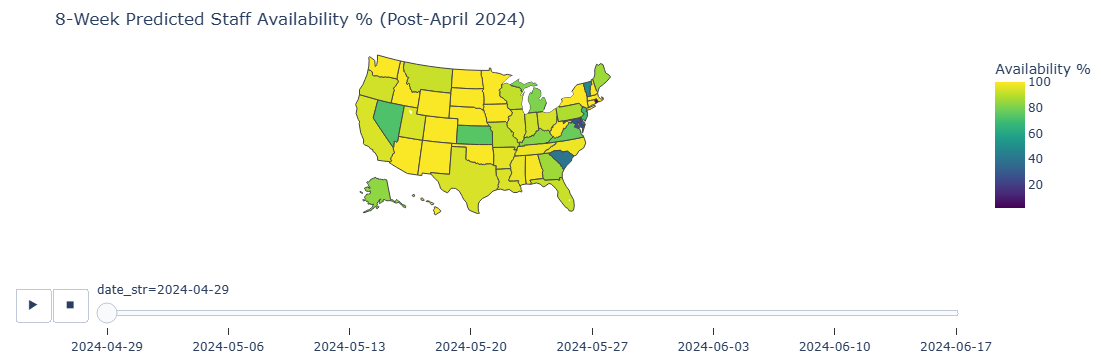

In [67]:
fig = px.choropleth(
    future_df,
    locations='state',
    locationmode='USA-states',
    color='Predicted Staff Availability %',
    hover_name='state',
    animation_frame='date_str',
    scope='usa',
    color_continuous_scale='Viridis',
    title='8-Week Predicted Staff Availability % (Post-April 2024)'
)

fig.update_layout(
    geo=dict(bgcolor='rgba(0,0,0,0)'),
    margin={"r":0,"t":50,"l":0,"b":0},
    coloraxis_colorbar=dict(title="Availability %")
)

fig.show()
